In [2]:
!kaggle datasets download rm1000/lung-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.55G/1.55G [00:14<00:00, 82.8MB/s]
100% 1.55G/1.55G [00:14<00:00, 119MB/s] 


In [3]:
!unzip /content/lung-cancer-histopathological-images.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/squamous_cell_carcinoma/0000.jpg  
  inflating: data/squamous_cell_carcinoma/0001.jpg  
  inflating: data/squamous_cell_carcinoma/0002.jpg  
  inflating: data/squamous_cell_carcinoma/0003.jpg  
  inflating: data/squamous_cell_carcinoma/0004.jpg  
  inflating: data/squamous_cell_carcinoma/0005.jpg  
  inflating: data/squamous_cell_carcinoma/0006.jpg  
  inflating: data/squamous_cell_carcinoma/0007.jpg  
  inflating: data/squamous_cell_carcinoma/0008.jpg  
  inflating: data/squamous_cell_carcinoma/0009.jpg  
  inflating: data/squamous_cell_carcinoma/0010.jpg  
  inflating: data/squamous_cell_carcinoma/0011.jpg  
  inflating: data/squamous_cell_carcinoma/0012.jpg  
  inflating: data/squamous_cell_carcinoma/0013.jpg  
  inflating: data/squamous_cell_carcinoma/0014.jpg  
  inflating: data/squamous_cell_carcinoma/0015.jpg  
  inflating: data/squamous_cell_carcinoma/0016.jpg  
  inflating: data/squamous_cell_carcinoma/0017.j

In [59]:
!pip install tensorflow

In [87]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense ,Flatten
from tensorflow.keras.optimizers import Adamax



In [69]:
data_dir = "/content/data"
image_data = [
    {"image_path": image_file, "label": label}
    for label in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, label))
    for image_file in glob(os.path.join(data_dir, label, "*.jpg"))
]

lung_df = pd.DataFrame(image_data)

In [70]:
lung_df.head()

,image_path,label
0,/content/data/adenocarcinoma/3420.jpg,adenocarcinoma
1,/content/data/adenocarcinoma/1783.jpg,adenocarcinoma
2,/content/data/adenocarcinoma/1212.jpg,adenocarcinoma
3,/content/data/adenocarcinoma/3884.jpg,adenocarcinoma
4,/content/data/adenocarcinoma/2909.jpg,adenocarcinoma


In [71]:
lung_df.describe()

,image_path,label
count,15000,15000
unique,15000,3
top,/content/data/adenocarcinoma/3420.jpg,adenocarcinoma
freq,1,5000


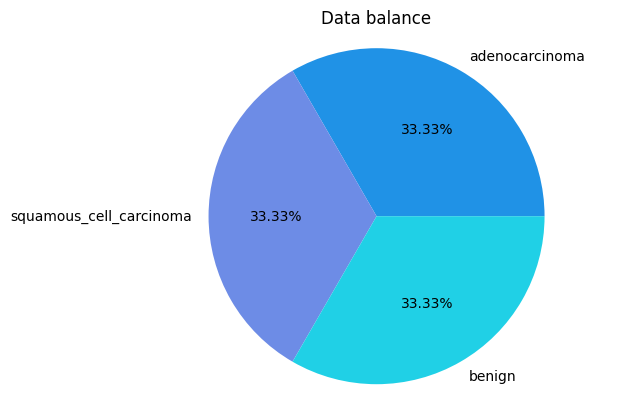

In [72]:
data_balance = lung_df.label.value_counts()
plt.pie(data_balance, labels = data_balance.index, autopct='%1.2f%%', colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

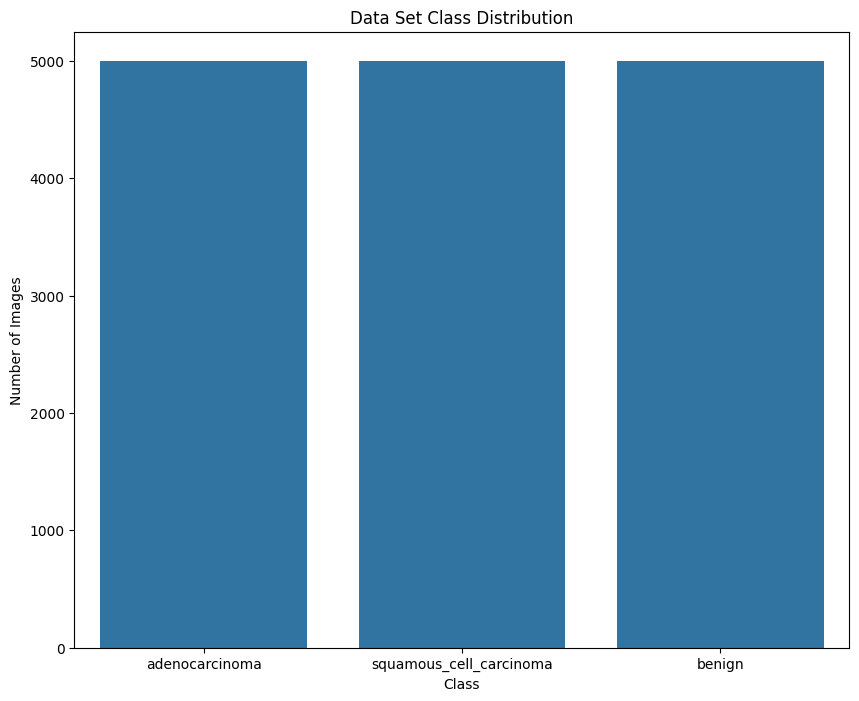

In [73]:
plt.subplots(figsize=(10,8))
sns.countplot(data=lung_df,x="label")
plt.title('Data Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [76]:
# lung_key = {'adenocarcinoma' : 1, 'benign' : 0,'squamous_cell_carcinoma' : 2}

# lung_df['label'] = lung_df['label'].map(lung_key)
# lung_df.head(10)

In [74]:
train_df, ts_df = train_test_split(lung_df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [75]:
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [98]:
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'b', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'b', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [82]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [89]:
model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adamax(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history=model.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 65s 170ms/step - accuracy: 0.6345 - loss: 4.5809 - val_accuracy: 0.6027 - val_loss: 1.4868
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - accuracy: 0.7107 - loss: 1.0660 - val_accuracy: 0.7733 - val_loss: 0.5770
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.7350 - loss: 0.7553 - val_accuracy: 0.7867 - val_loss: 0.4929
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - accuracy: 0.7456 - loss: 0.6192 - val_accuracy: 0.6707 - val_loss: 0.6838
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - accuracy: 0.7431 - loss: 0.5575 - val_accuracy: 0.7287 - val_loss: 0.5239
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - accuracy: 0.7500 - loss: 0.5282 - val_accuracy: 0.7560 - val_loss: 0.5451
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - accuracy: 0.7507 - loss: 0.5075 - val_accuracy: 0.7533 - val_loss: 0.4684
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - accuracy: 0.7650 - loss: 0

In [101]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 77%
Model Loss : 45%


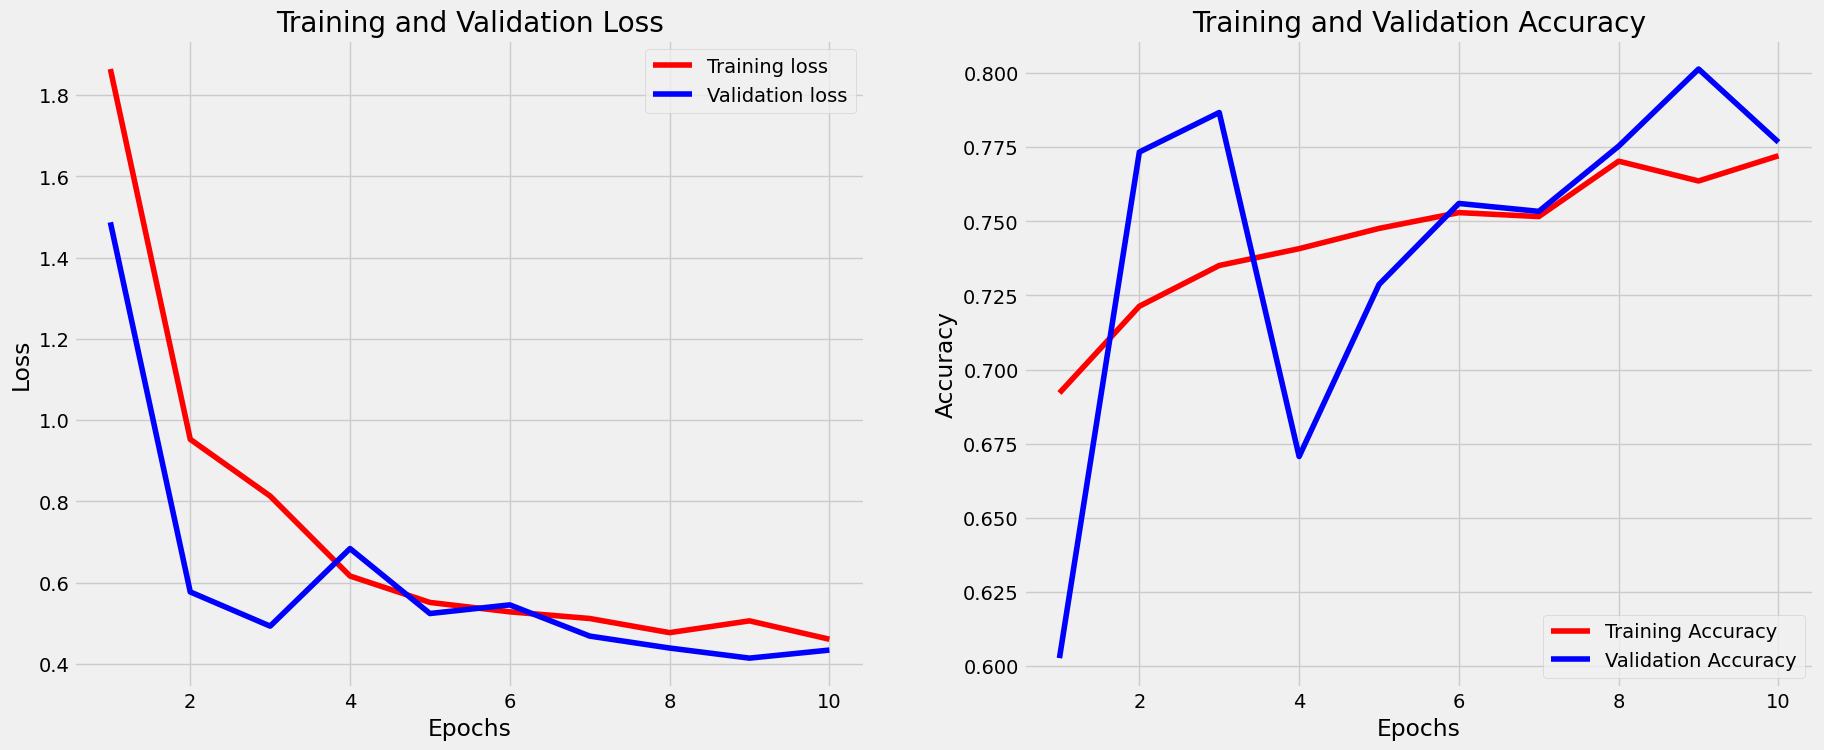

In [99]:
model_performance(history, 10)

In [103]:
model1 = Sequential()
model1.add(Input(shape=img_shape))
model1.add(Flatten())
model1.add(Dense(256, activation = 'relu'))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(class_counts, activation = 'softmax'))

model1.compile(Adamax(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history1=model1.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 161ms/step - accuracy: 0.6402 - loss: 2.2466 - val_accuracy: 0.6300 - val_loss: 1.9429
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - accuracy: 0.7028 - loss: 0.9694 - val_accuracy: 0.7667 - val_loss: 0.5026
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.7222 - loss: 0.7960 - val_accuracy: 0.7200 - val_loss: 0.6091
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.7525 - loss: 0.5619 - val_accuracy: 0.7860 - val_loss: 0.4436
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - accuracy: 0.7516 - loss: 0.5603 - val_accuracy: 0.7193 - val_loss: 0.6867
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - accuracy: 0.7447 - loss: 0.5668 - val_accuracy: 0.7980 - val_loss: 0.4238
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - accuracy: 0.7631 - loss: 0.4803 - val_accuracy: 0.7973 - val_loss: 0.4153
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - accuracy: 0.7657 - loss: 0

In [104]:
loss, accuracy = model1.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 76%
Model Loss : 48%


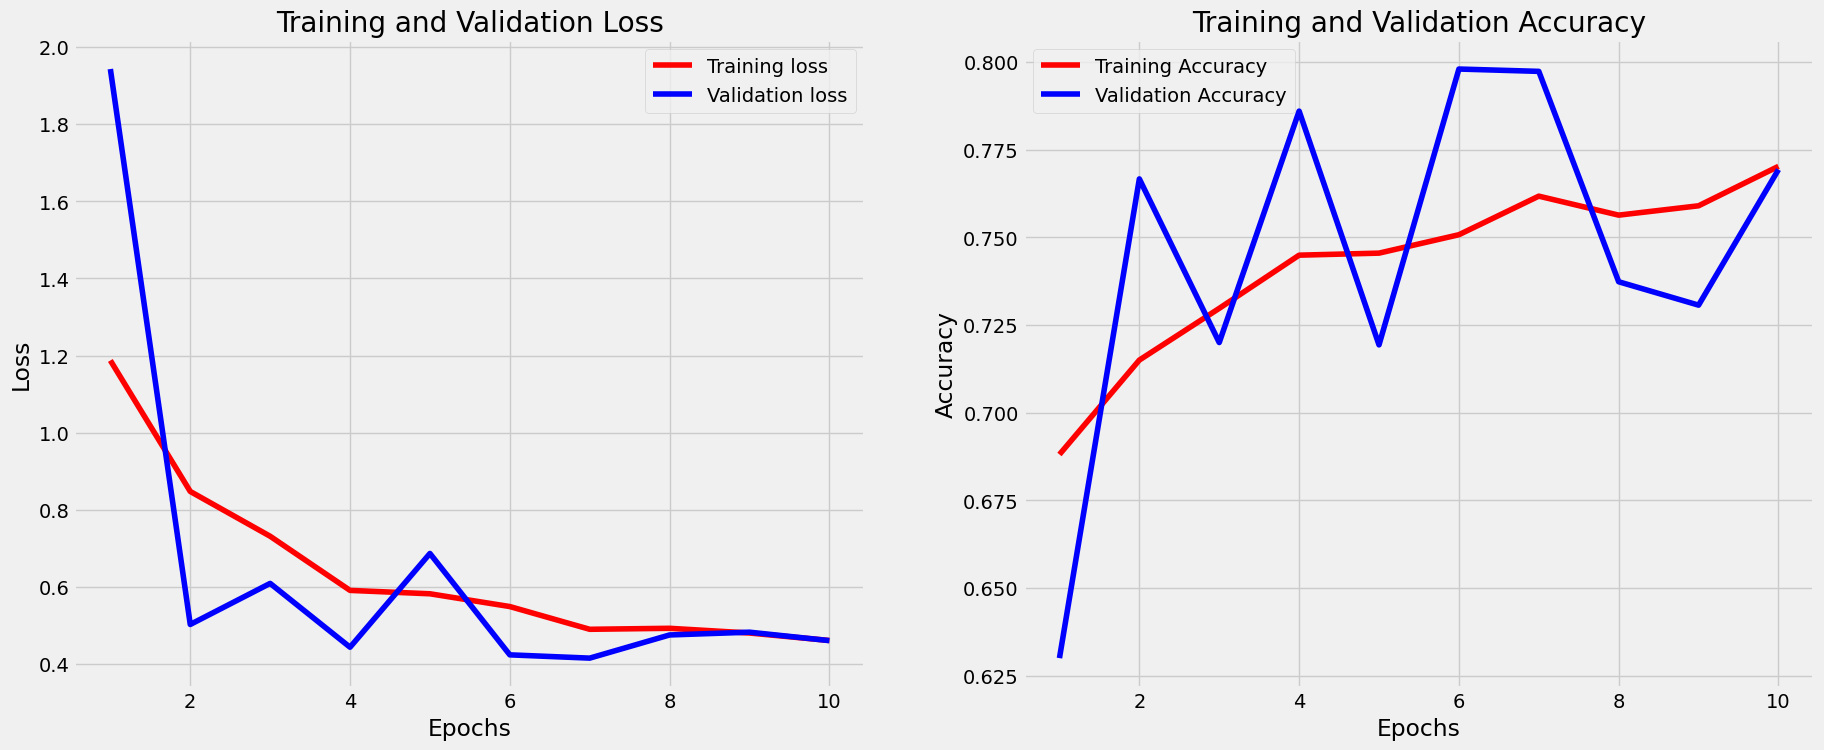

In [105]:
model_performance(history1, 10)